# Compare genres of input and output books

In [2]:
import gensim
from gensim.models import Doc2Vec, KeyedVectors
import logging
import time
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import requests
import matplotlib.pyplot as plt
import gensim.downloader as api # Downloading the Google pretrained Word2Vec Model

In [3]:
import numpy as np
import requests
import random
from tqdm.notebook import tqdm
tqdm.pandas()

In [4]:
import os
import json
import glob
import re
import sys
import collections
from nltk import flatten
import dask
from dask import delayed,compute
import dask.dataframe as dd
from dask.multiprocessing import get
import logging
from sklearn.metrics.pairwise import cosine_similarity

In [64]:
from sklearn.metrics import multilabel_confusion_matrix
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score,classification_report
from itertools import repeat

In [6]:
#read dataset
books_df = pd.read_csv('unique_books.csv')
#drop na (subset-genre)
books_df = books_df.dropna(subset=['genres'])
#remove quotes from around genre list
books_df['genres'] = books_df.loc[books_df['genres']!=np.nan, 'genres'].progress_apply(lambda x: ast.literal_eval(x))

  0%|          | 0/4326 [00:00<?, ?it/s]

In [7]:
#create list of genres
genres_list = []
for i in books_df['genres']:
    genres_list.extend(i)
#create unique list of genres
unique_genres_list = list(set(genres_list))
unique_genres_df = pd.DataFrame.from_dict({'genres': sorted(unique_genres_list)})
num_genres = len(unique_genres_list)
num_genres

424

## Step 1: 
Original books genres -> matrix

In [8]:
#Read in recommendations as df
avg_word_recs_df = pd.read_csv('paragraph_vec_recs_small_dataset.csv')

In [9]:
orig_book_indices = list(books_df.index)

In [10]:
num_orig_books = len(orig_book_indices)
num_orig_books

4326

In [11]:
recommended_books_df = avg_word_recs_df
recommended_books_df.head()

,Unnamed: 0,book_id,isbn,book_authors,book_title,genres,similarity_scores,orig_book_idx
0,1,26,307277674,['Dan Brown'],The Da Vinci Code,"['Fiction', 'Mystery', 'Thriller']",0.000235,0
1,3,33,739326228,['Arthur Golden'],Memoirs of a Geisha,"['Fiction', 'Historical', 'Historical Fiction'...",0.000083,0
2,7,388,689840926,['Gary Paulsen'],Hatchet,"['Young Adult', 'Fiction', 'Adventure', 'Class...",0.000038,0
3,29,778,451527887,"['Alain Erlande-Brandenburg', 'Caroline Rose',...",Notre-Dame de Paris,"['Classics', 'Nonfiction', 'History', 'Cultura...",0.000025,0
4,24,325,552135399,['John Irving'],A Prayer for Owen Meany,"['Fiction', 'Classics', 'Literature', 'Contemp...",0.000022,0


In [12]:
recommended_books_df.shape

(43300, 8)

In [13]:
missing_orig_books_indices_list = []
for idx in list(set(recommended_books_df['orig_book_idx'])):
    if idx not in orig_book_indices:
        missing_orig_books_indices_list.append(idx)

In [14]:
missing_orig_books_indices_list

[784, 3243, 4198, 4250]

In [15]:
recommended_books_df_rows_to_remove = []
for row_num in range(recommended_books_df.shape[0]):
    if recommended_books_df['orig_book_idx'][row_num] in (missing_orig_books_indices_list):
        recommended_books_df_rows_to_remove.append(row_num)

In [16]:
recommended_books_df_rows_to_remove

[7840,
 7841,
 7842,
 7843,
 7844,
 7845,
 7846,
 7847,
 7848,
 7849,
 32430,
 32431,
 32432,
 32433,
 32434,
 32435,
 32436,
 32437,
 32438,
 32439,
 41980,
 41981,
 41982,
 41983,
 41984,
 41985,
 41986,
 41987,
 41988,
 41989,
 42500,
 42501,
 42502,
 42503,
 42504,
 42505,
 42506,
 42507,
 42508,
 42509]

In [17]:
#remove books from recommended books that have orig books with those indices
recommended_books_df = recommended_books_df.drop(recommended_books_df_rows_to_remove, axis=0)

In [18]:
recommended_books_df.shape

(43260, 8)

In [19]:
#binarizer to transform between labels and a multilabel format
mlb = MultiLabelBinarizer()
#fit the binarizer to the list of genres
mlb.fit([unique_genres_list])

MultiLabelBinarizer()

In [20]:
orig_book_indices[-10:]

[4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329]

In [21]:
books_df.shape

(4326, 18)

In [22]:
num_preds_per_book = 10
orig_book_genres_matrix = []
for orig_book_index in orig_book_indices:
    orig_book = books_df.iloc[books_df.index==orig_book_index]
    orig_book_genres = orig_book['genres']
    orig_book_genres_matrix.extend(np.repeat(mlb.transform(orig_book_genres), repeats = num_preds_per_book, axis=0))

In [23]:
y_expected = np.array(orig_book_genres_matrix)

In [24]:
np.array(y_expected).shape

(43260, 424)

## Step 2
Predictions -> matrix with size = number of genres

In [25]:
#Cleaning: if genre = NaN, replace with '[]'
recommended_books_df.loc[recommended_books_df['genres'].isna(), 'genres']='[]'

In [26]:
#Cleaning
#recommended_books = recommended_books.dropna(subset=['genres'])
recommended_books_df['genres'] = recommended_books_df['genres'].progress_apply(lambda x: ast.literal_eval(x))

  0%|          | 0/43260 [00:00<?, ?it/s]

In [27]:
recommended_books_genres = list(recommended_books_df['genres'])


In [28]:
recommended_books_genres

[['Fiction', 'Mystery', 'Thriller'],
 ['Fiction', 'Historical', 'Historical Fiction', 'Romance', 'Historical'],
 ['Young Adult',
  'Fiction',
  'Adventure',
  'Classics',
  'Adventure',
  'Survival',
  'Childrens'],
 ['Classics',
  'Nonfiction',
  'History',
  'Cultural',
  'France',
  'Art',
  'Architecture'],
 ['Fiction', 'Classics', 'Literature', 'Contemporary'],
 ['Fiction', 'Classics', 'Philosophy', 'Literature'],
 ['Classics',
  'Fiction',
  'Academic',
  'School',
  'Literature',
  'Historical',
  'Historical Fiction',
  'Romance',
  'Novels',
  'Academic',
  'Read For School',
  'Young Adult',
  'High School',
  'Literature',
  'American'],
 ['Classics',
  'Fiction',
  'Literature',
  'Cultural',
  'Africa',
  'Academic',
  'School'],
 ['Fiction', 'Classics', 'Contemporary', 'Literature', 'Novels'],
 ['Fiction', 'Thriller', 'Mystery', 'Suspense', 'Spy Thriller', 'Espionage'],
 ['Historical', 'Historical Fiction', 'Fiction', 'Young Adult'],
 ['Nonfiction', 'Classics', 'Biography

In [29]:
rec_books_matrix = mlb.transform(recommended_books_genres)

In [30]:
rec_books_matrix.shape

(43260, 424)

In [31]:
rec_books_matrix[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [32]:
#create dataframe to hold evaluation metrics
eval_metrics = pd.DataFrame(columns = ['precision', 'recall','f1score'])
eval_metrics['precision'] = np.zeros(num_genres)
eval_metrics['recall'] = np.zeros(num_genres)
eval_metrics['f1score'] = np.zeros(num_genres)

In [33]:
y_pred = rec_books_matrix
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [34]:
len_y_pred = len(y_pred)

(array([  1.,   0.,   0.,   0.,   0.,   1.,   2.,   4.,   7., 409.]),
 array([0.31278728, 0.38148544, 0.4501836 , 0.51888175, 0.58757991,
        0.65627806, 0.72497622, 0.79367437, 0.86237253, 0.93107068,
        0.99976884]),
 <BarContainer object of 10 artists>)

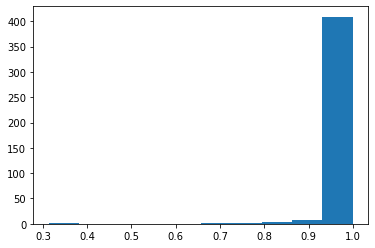

In [41]:
plt.hist(eval_metrics['precision'])

(array([  1.,   0.,   0.,   0.,   2.,   2.,   1.,   3.,  12., 403.]),
 array([0.41837037, 0.47653333, 0.5346963 , 0.59285926, 0.65102222,
        0.70918519, 0.76734815, 0.82551111, 0.88367407, 0.94183704,
        1.        ]),
 <BarContainer object of 10 artists>)

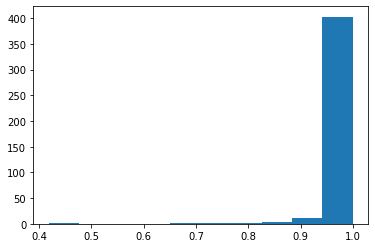

In [42]:
plt.hist(eval_metrics['recall'])

In [66]:
print(classification_report(
    y_expected,
    y_pred, output_dict=False))


/home/vkanoria/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       250
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        20
           6       0.00      0.01      0.01       340
           7       0.00      0.00      0.00       120
           8       0.00      0.00      0.00        10
           9       0.01      0.00      0.00       580
          10       0.02      0.00      0.00       370
          11       0.00      0.00      0.00        20
          12       0.02      0.06      0.03      1040
          13       0.03      0.03      0.03       990
          14       0.03      0.01      0.02      1870
          15       0.00      0.00      0.00       300
          16       0.02      0.01      0.01       300
          17       0.00    

/home/vkanoria/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
